In [7]:
import numpy as np 
import matplotlib.pyplot as plt
import nengo

# Hannas Test Net - Nengo

In [8]:
net = nengo.Network()

In [ ]:
with net:
    node1 = nengo.Node(output=0.5) # use output for input layer, poisson spike function with frequency = pixel intensity
    neurons = []
    for n in range(5):
        neurons.append(nengo.Ensemble(1,2))

# SNN Architecture Null Model

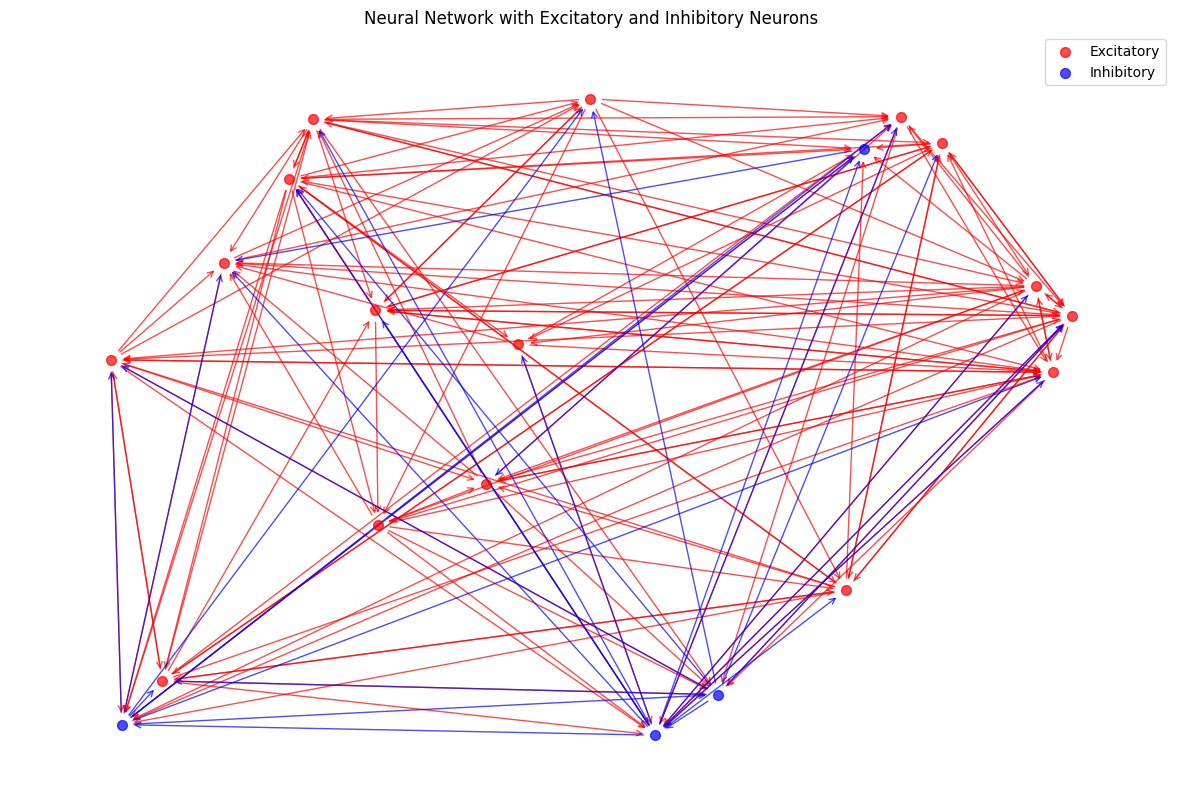

In [27]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def generate_neural_network(num_neurons, excitatory_ratio=0.8, connection_prob=0.1):
    """
    Generates a neural network with excitatory and inhibitory neurons.

    Args:
        num_neurons (int): Total number of neurons.
        excitatory_ratio (float): Proportion of excitatory neurons (default: 0.8, for 4:1 ratio).
        connection_prob (float): Probability of connection between any two neurons.
    
    Returns:
        G (nx.DiGraph): Directed graph representing the network.
    """
    # Number of excitatory and inhibitory neurons
    num_excitatory = int(num_neurons * excitatory_ratio)
    num_inhibitory = num_neurons - num_excitatory

    # Create directed graph
    G = nx.DiGraph()

    # Add nodes with attributes (excitatory or inhibitory)
    for i in range(num_neurons):
        if i < num_excitatory:
            G.add_node(i, type=1)
        else:
            G.add_node(i, type=-1)

    # Add edges with weights, respecting Dale's principle
    for i in range(num_neurons):
        for j in range(num_neurons):
            if i != j and np.random.rand() < connection_prob:
                if G.nodes[i]["type"] == 1:
                    weight = np.random.uniform(0.1, 1.0)  # Positive weight
                else:
                    weight = np.random.uniform(-1.0, -0.1)  # Negative weight
                G.add_edge(i, j, weight=weight)
    
    return G

def add_input_layer(G, num_input_nodes=10, subset_size=30, input_prob=0.5):
    """
    Adds an input layer to the neural network.

    Args:
        G (nx.DiGraph): Existing neural network graph.
        num_input_nodes (int): Number of input nodes to add.
        subset_size (int): Size of the subset of existing neurons to connect to.
        input_prob (float): Probability of connection from input nodes to subset neurons.

    Returns:
        G (nx.DiGraph): Updated graph with input layer.
    """
    num_existing_neurons = len(G.nodes)
    input_layer_start = num_existing_neurons

    # Add input nodes
    for i in range(num_input_nodes):
        G.add_node(input_layer_start + i, type="input")

    # Randomly select a subset of existing neurons
    subset_neurons = np.random.choice(num_existing_neurons, subset_size, replace=False)

    # Add edges from input nodes to subset neurons with the given probability
    for input_node in range(input_layer_start, input_layer_start + num_input_nodes):
        for target_neuron in subset_neurons:
            if np.random.rand() < input_prob:
                weight = np.random.uniform(0.1, 1.0)  # Positive weight for input connections
                G.add_edge(input_node, target_neuron, weight=weight)

    return G

def plot_network(G):
    """
    Plots the network, color-coding excitatory and inhibitory neurons.

    Args:
        G (nx.DiGraph): Directed graph representing the network.
    """
    pos = nx.random_layout(G)  # Layout for visualization
    excitatory_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == 1]
    inhibitory_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == -1]
    input_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == "input"]
    
    num_input_nodes = len(input_nodes)
    for i, node in enumerate(input_nodes):
        pos[node] = (-0.1, i / (num_input_nodes - 1) if num_input_nodes > 1 else 0.5)

    plt.figure(figsize=(15,10))
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, nodelist=excitatory_nodes, node_color="red", label="Excitatory", alpha=0.7, node_size=50)
    nx.draw_networkx_nodes(G, pos, nodelist=inhibitory_nodes, node_color="blue", label="Inhibitory", alpha=0.7, node_size=50)
    nx.draw_networkx_nodes(G, pos, nodelist=input_nodes, node_color="green", label="Input Nodes", alpha=0.7, node_size=50)

    # Draw edges
    weights = nx.get_edge_attributes(G, "weight")
    excitatory_edges = [(u, v) for u, v, d in G.edges(data=True) if d["weight"] > 0]
    inhibitory_edges = [(u, v) for u, v, d in G.edges(data=True) if d["weight"] < 0]
    input_edges = [(u, v) for u, v, d in G.edges(data=True) if G.nodes[u]["type"] == "input"]

    nx.draw_networkx_edges(G, pos, edgelist=excitatory_edges, edge_color="red", arrowstyle="->", arrowsize=10, alpha=0.7, label="Excitatory Connections")
    nx.draw_networkx_edges(G, pos, edgelist=inhibitory_edges, edge_color="blue", arrowstyle="->", arrowsize=10, alpha=0.7, label="Inhibitory Connections")
    nx.draw_networkx_edges(G, pos, edgelist=input_edges, edge_color="green", arrowstyle="->", arrowsize=10, alpha=0.7, label="Input Connections")


    # Add legend
    plt.legend()
    plt.title("Neural Network with Excitatory and Inhibitory Neurons")
    plt.axis("off")
    plt.show()

# Parameters
num_neurons = 20  # Total number of neurons
excitatory_ratio = 0.8  # 4:1 ratio (80% excitatory)
connection_prob = 0.4  # 10% connection probability

# Generate and plot network
G = generate_neural_network(num_neurons, excitatory_ratio, connection_prob)
#G = add_input_layer(G, num_input_nodes=10, subset_size=30, input_prob=0.5)
plot_network(G)

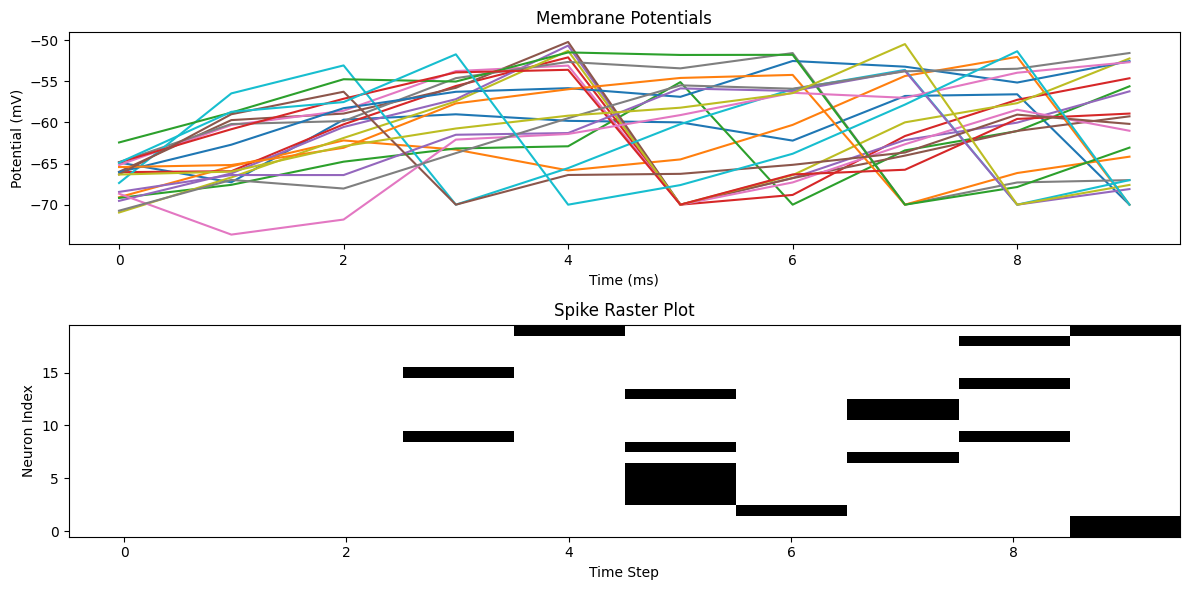

In [ ]:
import jax
import jax.numpy as jnp
from jax import random
from jax.lax import scan
import matplotlib.pyplot as plt

# Define neuron parameters
N = 20  # Number of neurons
EXCITATORY_RATIO = 0.8  # Ratio of excitatory neurons
EXCITATORY = 1
INHIBITORY = -1

# AdEx neuron model dynamics with STDP
def adex_dynamics(state, params, inputs):
    """Compute AdEx neuron dynamics with spiking."""
    v, w = state  # Membrane potential and adaptation variable
    I_ext, I_syn = inputs
    v_rest, v_th, delta_T, tau_v, a, b, tau_w, v_reset, refractory = params

    dvdt = (-(v - v_rest) + delta_T * jnp.exp((v - v_th) / delta_T) - w + I_ext + I_syn) / tau_v
    dwdt = (a * (v - v_rest) - w + b * (v > v_th)) / tau_w

    v_new = v + dvdt
    w_new = w + dwdt
    spiked = (v_new > v_th).astype(float)
    v_new = jnp.where(spiked, v_reset, v_new)  # Reset voltage on spike
    return jnp.array([v_new, w_new]), spiked

# Synaptic dynamics (calcium-based)
def synaptic_dynamics(state, params, pre_spike):
    """Compute calcium-based synaptic dynamics."""
    c = state  # Calcium level
    tau_c, alpha = params
    dcdt = -c / tau_c + alpha * pre_spike
    return c + dcdt

# Initialize network from graph
def initialize_from_graph(G, key):
    """Initialize neuron types and weights based on a NetworkX graph."""
    key, subkey = random.split(key)
    neuron_types = jnp.array([
        EXCITATORY if random.uniform(subkey) < EXCITATORY_RATIO else INHIBITORY for _ in G.nodes
    ])
    adjacency_matrix = jnp.array(nx.adjacency_matrix(G).todense())
    
    # Initialize weights based on adjacency matrix
    weights = random.uniform(subkey, shape=(N, N), minval=0.1, maxval=1.0) * adjacency_matrix
    return neuron_types, weights, adjacency_matrix

# Add noise to inputs
def noisy_input(key, N, mean=0.0, std=50.0):
    key, subkey = random.split(key)
    return random.normal(subkey, shape=(N,)) * std + mean

# Update weights using STDP
def update_weights(weights, pre_spikes, post_spikes, params):
    A_plus, A_minus, tau_plus, tau_minus = params
    pre_spikes = pre_spikes[:, None]  # Column vector
    post_spikes = post_spikes[None, :]  # Row vector
    delta_w_plus = A_plus * pre_spikes * post_spikes
    delta_w_minus = A_minus * pre_spikes * post_spikes.T
    weights += delta_w_plus - delta_w_minus
    return jnp.clip(weights, 0.1, 1.0)

# Update network state
def network_update(carry, t, LTP, LTD, params):
    neuron_states, synapse_states, weights, key = carry
    key, subkey1, subkey2, subkey3 = random.split(key, 4)

    # External noisy input (variation in external stimulation for a subset)
    I_ext = noisy_input(subkey1, N)
    
    # Pre-spikes from neuron states
    pre_spikes = (neuron_states[:, 0] > -50.0).astype(float)
    
    # Synaptic dynamics (update calcium levels based on pre-spikes)
    synapse_states = jax.vmap(synaptic_dynamics, in_axes=(0, None, 0))(
        synapse_states, (100.0, 1.0), pre_spikes
    )
    I_syn = jnp.dot(weights, synapse_states)  # Synaptic input from connected neurons
    
    # Neuron dynamics (AdEx model)
    neuron_states, spiked = jax.vmap(adex_dynamics, in_axes=(0, None, 0))(
        neuron_states, (0.0, -50.0, 2.0, 20.0, 0.01, 0.1, 100.0, -70.0, 5.0),
        jnp.stack([I_ext, I_syn], axis=-1)
    )
    
    # STDP weight updates (LTP and LTD)
    if LTP:
        weights = update_weights(weights, pre_spikes, spiked, (500, 100, 20.0, 20.0))
    if LTD:
        weights = update_weights(weights, pre_spikes, spiked, (100, 200, 20.0, 20.0))
    
    return (neuron_states, synapse_states, weights, key), (neuron_states[:, 0], spiked)

# Simulate network
def simulate(T, dt, G, key, LTP=True, LTD=True):
    neuron_types, weights, _ = initialize_from_graph(G, key)
    key, subkey1, subkey2 = random.split(key, 3)

    # Initial conditions for neuron states
    neuron_states = jnp.stack([
        random.uniform(subkey1, shape=(N,), minval=-70.0, maxval=-70.0),
        random.uniform(subkey2, shape=(N,), minval=0.0, maxval=5.0)
    ], axis=-1)
    
    # Synapse states (calcium dynamics)
    synapse_states = jnp.zeros(N)
    carry = (neuron_states, synapse_states, weights, key)
    time_steps = jnp.arange(0, T, dt)

    carry, outputs = scan(lambda carry, t: network_update(carry, t, LTP, LTD, (500, 100, 20.0, 20.0)), carry, time_steps)
    membrane_potentials, spikes = outputs
    return jnp.array(membrane_potentials).T, jnp.array(spikes).T, jnp.array(weights).T, time_steps

# Plot results
def plot_neuron_activity(time, membrane_potentials, spikes, weights):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time, membrane_potentials.T)
    plt.title('Membrane Potentials')
    plt.xlabel('Time (ms)')
    plt.ylabel('Potential (mV)')

    plt.subplot(2, 1, 2)
    plt.imshow(spikes, aspect='auto', cmap='gray_r', origin='lower')
    plt.title('Spike Raster Plot')
    plt.xlabel('Time Step')
    plt.ylabel('Neuron Index')
    plt.tight_layout()
    plt.show()
    

# Parameters
import networkx as nx
G = nx.DiGraph() # Increased connectivity probability for more interaction

key = random.PRNGKey(42)
T = 10  # Simulation time in ms
dt = 1.0  # Time step in ms

# Run simulation
membrane_potentials, spikes, weights, time = simulate(T, dt, G, key)

# Plot
plot_neuron_activity(time, membrane_potentials, spikes, weights)


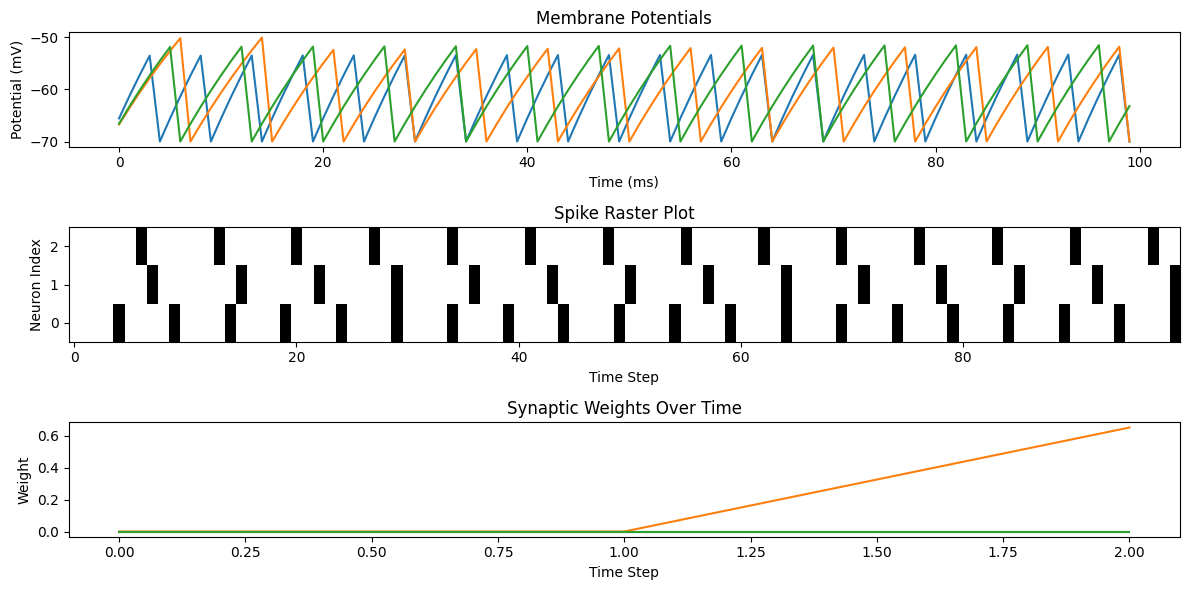

In [3]:
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import networkx as nx
from jax.lax import scan

# Define neuron parameters
N = 3 # Number of neurons
EXCITATORY_RATIO = 0.8  # Ratio of excitatory neurons
EXCITATORY = 1
INHIBITORY = -1

# AdEx neuron model dynamics with STDP
def adex_dynamics(state, params, inputs):
    """Compute AdEx neuron dynamics with spiking."""
    v, w = state  # Membrane potential and adaptation variable
    I_ext, I_syn = inputs
    v_rest, v_th, delta_T, tau_v, a, b, tau_w, v_reset, refractory = params

    dvdt = (-(v - v_rest) + delta_T * jnp.exp((v - v_th) / delta_T) - w + I_ext + I_syn) / tau_v
    dwdt = (a * (v - v_rest) - w + b * (v > v_th)) / tau_w

    v_new = v + dvdt
    w_new = w + dwdt
    spiked = (v_new > v_th).astype(float)
    v_new = jnp.where(spiked, v_reset, v_new)  # Reset voltage on spike
    return jnp.array([v_new, w_new]), spiked

# Synaptic dynamics (calcium-based)
def synaptic_dynamics(state, params, pre_spike):
    """Compute calcium-based synaptic dynamics."""
    c = state  # Calcium level
    tau_c, alpha = params
    dcdt = -c / tau_c + alpha * pre_spike
    return c + dcdt

# Initialize network from graph
def initialize_from_graph(G, key):
    """Initialize neuron types and weights based on a NetworkX graph."""
    key, subkey = random.split(key)
    neuron_types = jnp.array([
        EXCITATORY if random.uniform(subkey) < EXCITATORY_RATIO else INHIBITORY for _ in G.nodes
    ])
    adjacency_matrix = jnp.array(nx.adjacency_matrix(G).todense())
    
    # Initialize weights based on adjacency matrix
    weights = random.uniform(subkey, shape=(N, N), minval=0.1, maxval=1.0) * adjacency_matrix
    return neuron_types, weights, adjacency_matrix

# Add noise to inputs
# def noisy_input(key, N, mean=0.0, std=50.0):
#     key, subkey = random.split(key)
#     return random.normal(subkey, shape=(N,)) * std + mean

def noisy_input(key, N, constant_value=20.0, mean=0.0, std=0.0):
    key, subkey = random.split(key)
    # Create a normal distribution for the last (N-10) neurons
    normal_input = random.normal(subkey, shape=(N-1,)) * std + mean
    # For the first 10 neurons, use the constant value
    constant_input = jnp.full((1,), constant_value)
    # Combine both inputs
    return jnp.concatenate([constant_input, normal_input])


# Update weights using STDP
def update_weights(weights, pre_spikes, post_spikes, params):
    A_plus, A_minus, tau_plus, tau_minus = params
    pre_spikes = pre_spikes[:, None]  # Column vector
    post_spikes = post_spikes[None, :]  # Row vector
    delta_w_plus = A_plus * pre_spikes * post_spikes
    delta_w_minus = A_minus * pre_spikes * post_spikes.T
    weights += delta_w_plus - delta_w_minus
    return jnp.clip(weights, 0.1, 1.0)

# Update network state
def network_update(carry, t, LTP, LTD, params):
    neuron_states, synapse_states, weights, key = carry
    key, subkey1, subkey2, subkey3 = random.split(key, 4)

    # External noisy input (variation in external stimulation for a subset)
    I_ext = noisy_input(subkey1, N)
    
    # Pre-spikes from neuron states
    pre_spikes = (neuron_states[:, 0] > -50.0).astype(float)
    
    # Synaptic dynamics (update calcium levels based on pre-spikes)
    synapse_states = jax.vmap(synaptic_dynamics, in_axes=(0, None, 0))(
        synapse_states, (100.0, 1.0), pre_spikes
    )
    I_syn = jnp.dot(weights, synapse_states)  # Synaptic input from connected neurons
    
    # Neuron dynamics (AdEx model)
    neuron_states, spiked = jax.vmap(adex_dynamics, in_axes=(0, None, 0))(
        neuron_states, (0.0, -50.0, 2.0, 20.0, 0.01, 0.1, 100.0, -70.0, 5.0),
        jnp.stack([I_ext, I_syn], axis=-1)
    )
    
    # STDP weight updates (LTP and LTD)
    if LTP:
        weights = update_weights(weights, pre_spikes, spiked, (500, 100, 20.0, 20.0))
    if LTD:
        weights = update_weights(weights, pre_spikes, spiked, (100, 200, 20.0, 20.0))
    
    return (neuron_states, synapse_states, weights, key), (neuron_states[:, 0], spiked)

# Simulate network
def simulate(T, dt, G, key, LTP=True, LTD=True):
    neuron_types, weights, _ = initialize_from_graph(G, key)
    key, subkey1, subkey2 = random.split(key, 3)

    # Initial conditions for neuron states
    neuron_states = jnp.stack([
        random.uniform(subkey1, shape=(N,), minval=-70.0, maxval=-70.0),
        random.uniform(subkey2, shape=(N,), minval=0.0, maxval=5.0)
    ], axis=-1)
    
    # Synapse states (calcium dynamics)
    synapse_states = jnp.zeros(N)
    carry = (neuron_states, synapse_states, weights, key)
    time_steps = jnp.arange(0, T, dt)

    carry, outputs = scan(lambda carry, t: network_update(carry, t, LTP, LTD, (500, 100, 20.0, 20.0)), carry, time_steps)
    membrane_potentials, spikes = outputs
    return jnp.array(membrane_potentials).T, jnp.array(spikes).T, jnp.array(weights).T, time_steps

# Plot results
def plot_neuron_activity(time, membrane_potentials, spikes, weights):
    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 1)
    plt.plot(time, membrane_potentials.T)
    plt.title('Membrane Potentials')
    plt.xlabel('Time (ms)')
    plt.ylabel('Potential (mV)')

    plt.subplot(3, 1, 2)
    plt.imshow(spikes, aspect='auto', cmap='gray_r', origin='lower')
    plt.title('Spike Raster Plot')
    plt.xlabel('Time Step')
    plt.ylabel('Neuron Index')
    
    # Plot weights of a few neurons
    plt.subplot(3,1,3)
    plt.plot(weights[:, :])  # Plot weights for first 5 neurons
    plt.title('Synaptic Weights Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Weight')
    plt.tight_layout()
    plt.show()
    
# doesn't handle weights correctly

# Parameters
#G = nx.erdos_renyi_graph(N, 0.3)  # Increased connectivity probability for more interaction
G = nx.DiGraph()
G.add_node(1)
G.add_node(2)
G.add_node(2)
#G.add_edge(1,2)
G.add_edge(2,3)
key = random.PRNGKey(42)
T = 100  # Simulation time in ms
dt = 1.0  # Time step in ms

# Run simulation
membrane_potentials, spikes, weights, time = simulate(T, dt, G, key)

# Plot
plot_neuron_activity(time, membrane_potentials, spikes, weights)


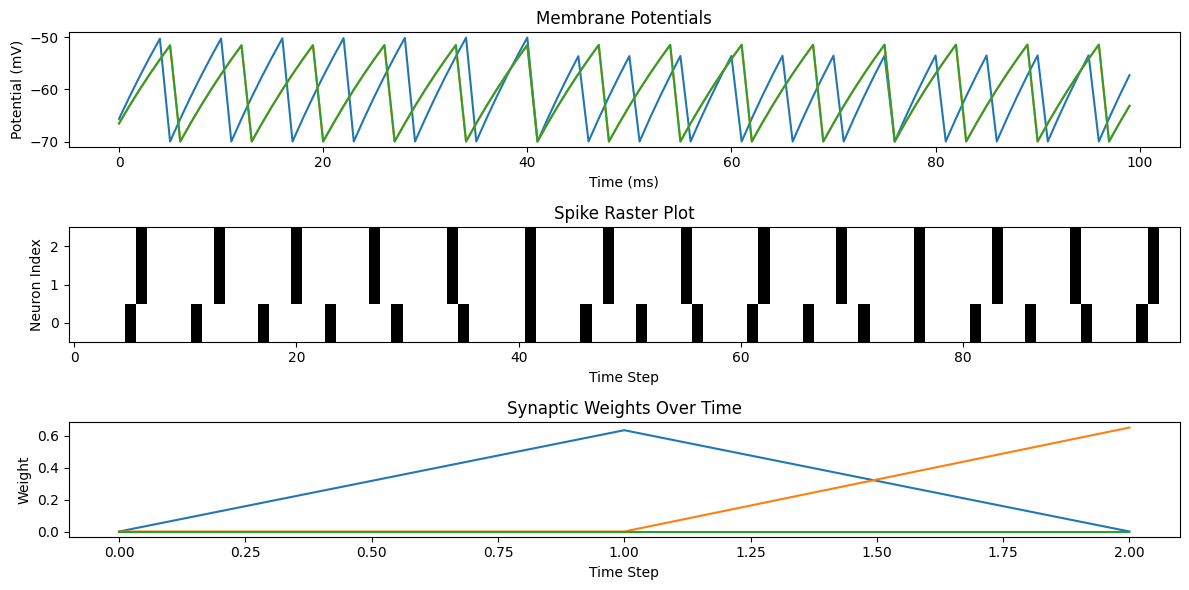

In [5]:
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import networkx as nx
from jax.lax import scan

# Define neuron parameters
N = 3  # Number of neurons
EXCITATORY_RATIO = 0.8  # Ratio of excitatory neurons
EXCITATORY = 1
INHIBITORY = -1

# AdEx neuron model dynamics
def adex_dynamics(state, params, inputs):
    """Compute AdEx neuron dynamics with spiking."""
    v, w = state  # Membrane potential and adaptation variable
    I_ext, I_syn = inputs
    v_rest, v_th, delta_T, tau_v, a, b, tau_w, v_reset, refractory = params

    dvdt = (-(v - v_rest) + delta_T * jnp.exp((v - v_th) / delta_T) - w + I_ext + I_syn) / tau_v
    dwdt = (a * (v - v_rest) - w + b * (v > v_th)) / tau_w

    v_new = v + dvdt
    w_new = w + dwdt
    spiked = (v_new > v_th).astype(float)
    v_new = jnp.where(spiked, v_reset, v_new)  # Reset voltage on spike
    return jnp.array([v_new, w_new]), spiked

# Exponential synapse dynamics
def synaptic_dynamics(syn_state, tau_syn, pre_spike):
    """Exponential synaptic dynamics."""
    dsdt = -syn_state / tau_syn + pre_spike
    return syn_state + dsdt

# Initialize network from graph
def initialize_from_graph(G, key):
    """Initialize neuron types and weights based on a NetworkX graph."""
    key, subkey = random.split(key)
    neuron_types = jnp.array([
        EXCITATORY if random.uniform(subkey) < EXCITATORY_RATIO else INHIBITORY for _ in G.nodes
    ])
    adjacency_matrix = jnp.array(nx.adjacency_matrix(G).todense())
    weights = random.uniform(subkey, shape=(N, N), minval=0.1, maxval=1.0) * adjacency_matrix
    return neuron_types, weights, adjacency_matrix

# Add noise to inputs
def noisy_input(key, N, stimulated_neuron=0, constant_value=20.0):
    key, subkey = random.split(key)
    input_current = jnp.zeros(N)  # Initialize with zero input
    input_current = input_current.at[stimulated_neuron].set(constant_value)  # Stimulate only the first neuron
    return input_current

# Apply connectivity mask to weights
def apply_connectivity_mask(weights, adjacency_matrix):
    return weights * adjacency_matrix

# Update weights using STDP
def update_weights(weights, pre_spikes, post_spikes, params):
    A_plus, A_minus, tau_plus, tau_minus = params
    pre_spikes = pre_spikes[:, None]  # Column vector
    post_spikes = post_spikes[None, :]  # Row vector
    delta_w_plus = A_plus * pre_spikes * post_spikes
    delta_w_minus = A_minus * pre_spikes * post_spikes.T
    weights += delta_w_plus - delta_w_minus
    return jnp.clip(weights, 0.1, 1.0)

# Update network state
def network_update(carry, t, LTP, LTD, params):
    neuron_states, synapse_states, weights, key = carry
    key, subkey1, subkey2 = random.split(key, 3)

    # External input
    I_ext = noisy_input(subkey1, N)
    
    # Pre-spikes from neuron states
    pre_spikes = (neuron_states[:, 0] > -50.0).astype(float)
    
    # Synaptic dynamics (exponential synapse)
    synapse_states = jax.vmap(synaptic_dynamics, in_axes=(0, None, 0))(
        synapse_states, 10.0, pre_spikes  # tau_syn = 10.0
    )
    I_syn = jnp.dot(weights, synapse_states)  # Synaptic input from connected neurons
    
    # Neuron dynamics (AdEx model)
    neuron_states, spiked = jax.vmap(adex_dynamics, in_axes=(0, None, 0))(
        neuron_states, (0.0, -50.0, 2.0, 20.0, 0.01, 0.1, 100.0, -70.0, 5.0),
        jnp.stack([I_ext, I_syn], axis=-1)
    )
    
    # STDP weight updates (LTP and LTD)
    if LTP:
        weights = update_weights(weights, pre_spikes, spiked, (0.01, 0.005, 20.0, 20.0))
    if LTD:
        weights = update_weights(weights, pre_spikes, spiked, (0.005, 0.01, 20.0, 20.0))
    
    return (neuron_states, synapse_states, weights, key), (neuron_states[:, 0], spiked)

# Simulate network
def simulate(T, dt, G, key, LTP=True, LTD=True):
    neuron_types, weights, adjacency_matrix = initialize_from_graph(G, key)
    weights = apply_connectivity_mask(weights, adjacency_matrix)  # Mask weights

    # Initial conditions for neuron states
    neuron_states = jnp.stack([
        random.uniform(key, shape=(N,), minval=-70.0, maxval=-70.0),
        random.uniform(key, shape=(N,), minval=0.0, maxval=5.0)
    ], axis=-1)
    
    # Synapse states (exponential synapse)
    synapse_states = jnp.zeros(N)
    carry = (neuron_states, synapse_states, weights, key)
    time_steps = jnp.arange(0, T, dt)

    carry, outputs = scan(lambda carry, t: network_update(carry, t, LTP, LTD, (0.01, 0.005, 20.0, 20.0)), carry, time_steps)
    membrane_potentials, spikes = outputs
    return jnp.array(membrane_potentials).T, jnp.array(spikes).T, jnp.array(weights).T, time_steps

# Plot results
def plot_neuron_activity(time, membrane_potentials, spikes, weights):
    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 1)
    plt.plot(time, membrane_potentials.T)
    plt.title('Membrane Potentials')
    plt.xlabel('Time (ms)')
    plt.ylabel('Potential (mV)')

    plt.subplot(3, 1, 2)
    plt.imshow(spikes, aspect='auto', cmap='gray_r', origin='lower')
    plt.title('Spike Raster Plot')
    plt.xlabel('Time Step')
    plt.ylabel('Neuron Index')
    
    # Plot weights of all neurons
    plt.subplot(3, 1, 3)
    plt.plot(weights)
    plt.title('Synaptic Weights Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Weight')
    plt.tight_layout()
    plt.show()

# Parameters
G = nx.DiGraph()
G.add_edge(0, 1)  # Neuron 0 influences Neuron 1
G.add_edge(1, 2)  # Neuron 1 influences Neuron 2
key = random.PRNGKey(42)
T = 100  # Simulation time in ms
dt = 1.0  # Time step in ms

# Run simulation
membrane_potentials, spikes, weights, time = simulate(T, dt, G, key)

# Plot
plot_neuron_activity(time, membrane_potentials, spikes, weights)


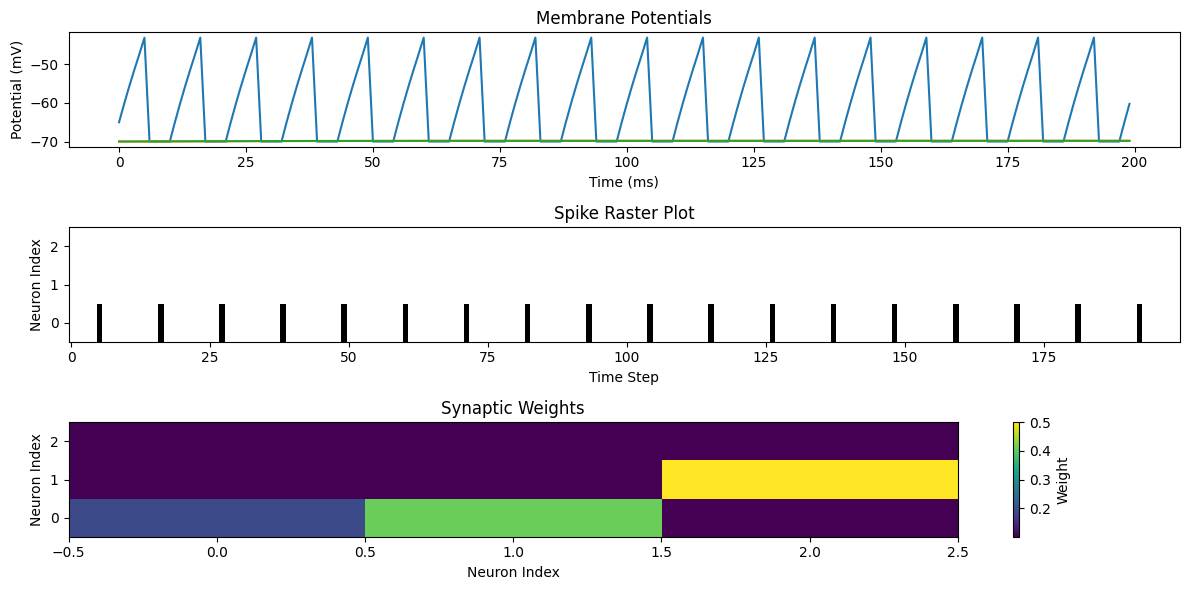

[[0.18999995 0.4100001  0.1       ]
 [0.1        0.1        0.5       ]
 [0.1        0.1        0.1       ]]


In [9]:
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import networkx as nx
from jax.lax import scan

# Define parameters
params = {
    "neuron": {
        "v_rest": -70.0,  # Resting membrane potential (mV)
        "v_th": -50.0,    # Threshold potential (mV)
        "delta_T": 2.0,   # Slope factor (mV)
        "tau_v": 20.0,    # Membrane time constant (ms)
        "a": 0.01,        # Subthreshold adaptation (nS)
        "b": 0.1,         # Spike-triggered adaptation (nA)
        "tau_w": 100.0,   # Adaptation time constant (ms)
        "v_reset": -70.0, # Reset potential after spike (mV)
        "refractory": 5.0 # Refractory period (ms)
    },
    "synapse": {
        "tau_syn": 10.0  # Synaptic time constant (ms)
    },
    "stdp": {
        "A_plus": 0.01,   # STDP LTP increment
        "A_minus": 0.005, # STDP LTD decrement
        "tau_plus": 20.0, # STDP LTP time constant (ms)
        "tau_minus": 20.0 # STDP LTD time constant (ms)
    }
}

# AdEx neuron dynamics
# AdEx neuron dynamics
def adex_dynamics(state, neuron_params, inputs):
    """AdEx neuron dynamics with spiking and refractory period."""
    v, w, refractory_timer = state
    I_ext, I_syn = inputs

    # Check if the neuron is in a refractory period
    refractory_logic = lambda _: (
        neuron_params["v_reset"], w, refractory_timer - 1, 0.0
    )

    # Normal dynamics logic
    normal_logic = lambda _: (
        # Update membrane potential
        v + (-(v - neuron_params["v_rest"])
             + neuron_params["delta_T"] * jnp.exp((v - neuron_params["v_th"]) / neuron_params["delta_T"])
             - w + I_ext + I_syn) / neuron_params["tau_v"],
        # Update adaptation
        w + (neuron_params["a"] * (v - neuron_params["v_rest"]) - w +
             neuron_params["b"] * (v > neuron_params["v_th"])) / neuron_params["tau_w"],
        # Refractory timer
        jnp.where(v > neuron_params["v_th"], neuron_params["refractory"], 0.0),
        # Spiking
        (v > neuron_params["v_th"]).astype(float)
    )

    v_new, w_new, refractory_timer_new, spiked = jax.lax.cond(
        refractory_timer > 0, refractory_logic, normal_logic, operand=None
    )

    return jnp.array([v_new, w_new, refractory_timer_new]), spiked


# Exponential synapse dynamics
def synaptic_dynamics(syn_state, syn_params, pre_spike):
    """Exponential synaptic dynamics."""
    dsdt = -syn_state / syn_params["tau_syn"] + pre_spike
    return syn_state + dsdt

# STDP weight updates
def update_weights(weights, pre_spikes, post_spikes, stdp_params):
    """Update synaptic weights using STDP rules."""
    pre_spikes = pre_spikes[:, None]  # Column vector
    post_spikes = post_spikes[None, :]  # Row vector
    delta_w_plus = stdp_params["A_plus"] * pre_spikes * post_spikes
    delta_w_minus = stdp_params["A_minus"] * pre_spikes * post_spikes.T
    weights += delta_w_plus - delta_w_minus
    return jnp.clip(weights, 0.1, 1.0)

# Network simulation
def network_update(carry, t, params):
    neuron_states, synapse_states, weights, key = carry
    key, subkey = random.split(key)

    # External input: stimulate only the first neuron
    I_ext = jnp.zeros(len(neuron_states))
    I_ext = I_ext.at[0].set(100.0)

    # Pre-spikes from the previous step
    pre_spikes = (neuron_states[:, 0] > -50.0).astype(float)

    # Synaptic dynamics: update based on pre-spikes
    synapse_states = jax.vmap(synaptic_dynamics, in_axes=(0, None, 0))(
        synapse_states, params["synapse"], pre_spikes
    )
    I_syn = jnp.dot(weights, synapse_states)

    # Neuron dynamics: update states and compute spiking
    neuron_states, spiked = jax.vmap(adex_dynamics, in_axes=(0, None, 0))(
        neuron_states, params["neuron"], jnp.stack([I_ext, I_syn], axis=-1)
    )

    # STDP weight updates
    weights = update_weights(weights, pre_spikes, spiked, params["stdp"])

    return (neuron_states, synapse_states, weights, key), (neuron_states[:, 0], spiked)

def simulate(T, dt, G, key, params):
    # Initialize neuron states, synapse states, and weights
    N = len(G.nodes)
    neuron_states = jnp.stack([
        jnp.full((N,), params["neuron"]["v_rest"]),  # Membrane potential
        jnp.zeros(N),                               # Adaptation variable
        jnp.zeros(N)                                # Refractory timer
    ], axis=-1)
    synapse_states = jnp.zeros(N)  # Synaptic states
    weights = jnp.array(nx.adjacency_matrix(G).todense()) * 0.5
    carry = (neuron_states, synapse_states, weights, key)
    time_steps = jnp.arange(0, T, dt)

    # Simulate the network
    carry, outputs = scan(lambda carry, t: network_update(carry, t, params), carry, time_steps)
    membrane_potentials, spikes = outputs
    return jnp.array(membrane_potentials).T, jnp.array(spikes).T, carry[2], time_steps

# Plotting functions
def plot_results(time, membrane_potentials, spikes, weights):
    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 1)
    plt.plot(time, membrane_potentials.T)
    plt.title("Membrane Potentials")
    plt.xlabel("Time (ms)")
    plt.ylabel("Potential (mV)")

    plt.subplot(3, 1, 2)
    plt.imshow(spikes, aspect="auto", cmap="gray_r", origin="lower")
    plt.title("Spike Raster Plot")
    plt.xlabel("Time Step")
    plt.ylabel("Neuron Index")

    plt.subplot(3, 1, 3)
    plt.imshow(weights, aspect="auto", cmap="viridis", origin="lower")
    plt.title("Synaptic Weights")
    plt.xlabel("Neuron Index")
    plt.ylabel("Neuron Index")
    plt.colorbar(label="Weight")
    plt.tight_layout()
    plt.show()
    print(weights)

# Define a simple feedforward network
G = nx.DiGraph()
G.add_edge(0, 1)
G.add_edge(1, 2)

# Parameters
key = random.PRNGKey(42)
T = 200  # Simulation time (ms)
dt = 1.0  # Time step (ms)

# Simulate and plot
membrane_potentials, spikes, final_weights, time = simulate(T, dt, G, key, params)
plot_results(time, membrane_potentials, spikes, final_weights)


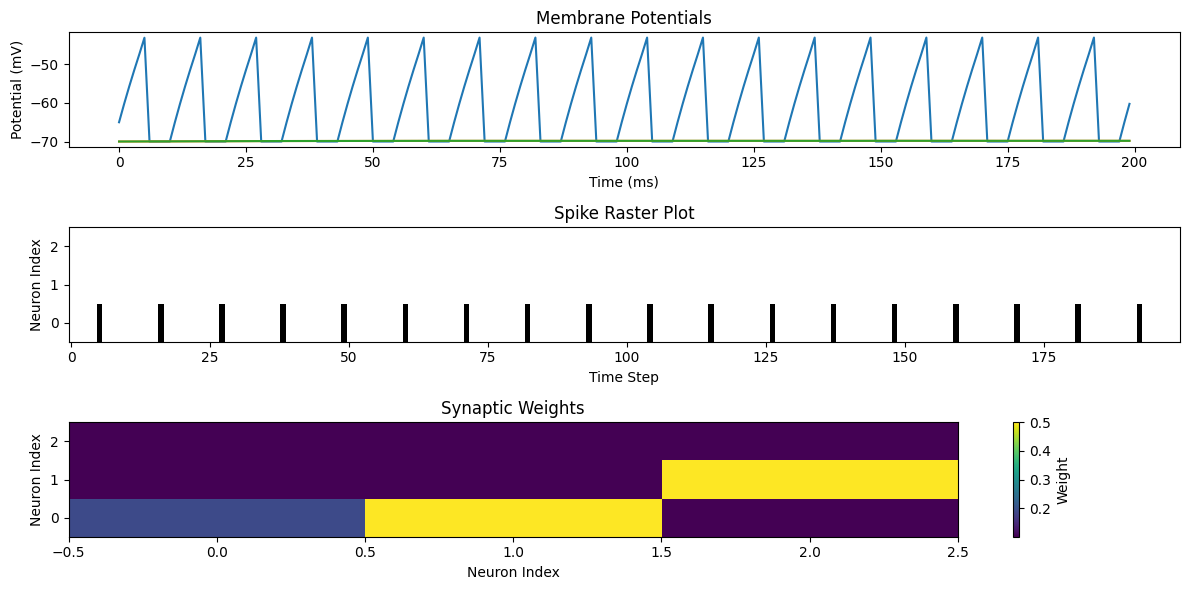

In [11]:
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
from jax.lax import scan

# Define parameters
params = {
    "neuron": {
        "v_rest": -70.0,  # Resting membrane potential (mV)
        "v_th": -50.0,    # Threshold potential (mV)
        "delta_T": 2.0,   # Slope factor (mV)
        "tau_v": 20.0,    # Membrane time constant (ms)
        "a": 0.01,        # Subthreshold adaptation (nS)
        "b": 0.1,         # Spike-triggered adaptation (nA)
        "tau_w": 100.0,   # Adaptation time constant (ms)
        "v_reset": -70.0, # Reset potential after spike (mV)
        "refractory": 5.0 # Refractory period (ms)
    },
    "synapse": {
        "tau_syn": 10.0  # Synaptic time constant (ms)
    },
    "stdp": {
        "A_plus": 0.01,   # STDP LTP increment
        "A_minus": 0.005, # STDP LTD decrement
        "tau_plus": 20.0, # STDP LTP time constant (ms)
        "tau_minus": 20.0 # STDP LTD time constant (ms)
    }
}

# AdEx neuron dynamics
def adex_dynamics(state, neuron_params, inputs):
    """AdEx neuron dynamics with spiking and refractory period."""
    v, w, refractory_timer = state
    I_ext, I_syn = inputs

    refractory_logic = lambda _: (
        neuron_params["v_reset"], w, refractory_timer - 1, 0.0
    )

    normal_logic = lambda _: (
        v + (-(v - neuron_params["v_rest"])
             + neuron_params["delta_T"] * jnp.exp((v - neuron_params["v_th"]) / neuron_params["delta_T"])
             - w + I_ext + I_syn) / neuron_params["tau_v"],
        w + (neuron_params["a"] * (v - neuron_params["v_rest"]) - w +
             neuron_params["b"] * (v > neuron_params["v_th"])) / neuron_params["tau_w"],
        jnp.where(v > neuron_params["v_th"], neuron_params["refractory"], 0.0),
        (v > neuron_params["v_th"]).astype(float)
    )

    v_new, w_new, refractory_timer_new, spiked = jax.lax.cond(
        refractory_timer > 0, refractory_logic, normal_logic, operand=None
    )

    return jnp.array([v_new, w_new, refractory_timer_new]), spiked

# Exponential synapse dynamics
def synaptic_dynamics(syn_state, syn_params, pre_spike):
    """Exponential synaptic dynamics."""
    return syn_state + (-syn_state / syn_params["tau_syn"] + pre_spike)

# STDP weight updates
def update_weights(weights, pre_spikes, post_spikes, stdp_params):
    """Update synaptic weights using STDP rules."""
    delta_w_plus = stdp_params["A_plus"] * pre_spikes[:, None] * post_spikes[None, :]
    delta_w_minus = stdp_params["A_minus"] * post_spikes[:, None] * pre_spikes[None, :]
    weights += delta_w_plus - delta_w_minus
    return jnp.clip(weights, 0.1, 1.0)

# Network update function
def network_update(carry, t, params):
    neuron_states, synapse_states, weights, key = carry
    key, subkey = random.split(key)

    # External input: stimulate neuron 0 for demonstration
    I_ext = jnp.zeros(len(neuron_states))
    I_ext = I_ext.at[0].set(100.0)

    pre_spikes = (neuron_states[:, 0] > params["neuron"]["v_th"]).astype(float)

    # Synaptic dynamics: update synapse states
    synapse_states = jax.vmap(synaptic_dynamics, in_axes=(0, None, 0))(
        synapse_states, params["synapse"], pre_spikes
    )
    I_syn = jnp.dot(weights, synapse_states)

    # Neuron dynamics: update states
    neuron_states, spiked = jax.vmap(adex_dynamics, in_axes=(0, None, 0))(
        neuron_states, params["neuron"], jnp.stack([I_ext, I_syn], axis=-1)
    )

    # Update weights
    weights = update_weights(weights, pre_spikes, spiked, params["stdp"])

    return (neuron_states, synapse_states, weights, key), (neuron_states[:, 0], spiked)

# Simulation
def simulate(T, dt, N, key, params, connectivity):
    neuron_states = jnp.stack([
        jnp.full((N,), params["neuron"]["v_rest"]),
        jnp.zeros(N),
        jnp.zeros(N)
    ], axis=-1)
    synapse_states = jnp.zeros(N)
    weights = jnp.array(connectivity) * 0.5
    carry = (neuron_states, synapse_states, weights, key)
    time_steps = jnp.arange(0, T, dt)

    carry, outputs = scan(lambda carry, t: network_update(carry, t, params), carry, time_steps)
    membrane_potentials, spikes = outputs
    return jnp.array(membrane_potentials).T, jnp.array(spikes).T, carry[2], time_steps

# Plotting results
def plot_results(time, membrane_potentials, spikes, weights):
    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 1)
    plt.plot(time, membrane_potentials.T)
    plt.title("Membrane Potentials")
    plt.xlabel("Time (ms)")
    plt.ylabel("Potential (mV)")

    plt.subplot(3, 1, 2)
    plt.imshow(spikes, aspect="auto", cmap="gray_r", origin="lower")
    plt.title("Spike Raster Plot")
    plt.xlabel("Time Step")
    plt.ylabel("Neuron Index")

    plt.subplot(3, 1, 3)
    plt.imshow(weights, aspect="auto", cmap="viridis", origin="lower")
    plt.title("Synaptic Weights")
    plt.xlabel("Neuron Index")
    plt.ylabel("Neuron Index")
    plt.colorbar(label="Weight")
    plt.tight_layout()
    plt.show()

# Define the connectivity matrix
N = 3
connectivity = jnp.array([
    [0.0, 1.0, 0.0],  # Neuron 0 connects to Neuron 1
    [0.0, 0.0, 1.0],  # Neuron 1 connects to Neuron 2
    [0.0, 0.0, 0.0]   # Neuron 2 has no outgoing connections
])

# Simulation parameters
key = random.PRNGKey(42)
T = 200  # Simulation time (ms)
dt = 1.0  # Time step (ms)

# Run the simulation
membrane_potentials, spikes, final_weights, time = simulate(T, dt, N, key, params, connectivity)
plot_results(time, membrane_potentials, spikes, final_weights)


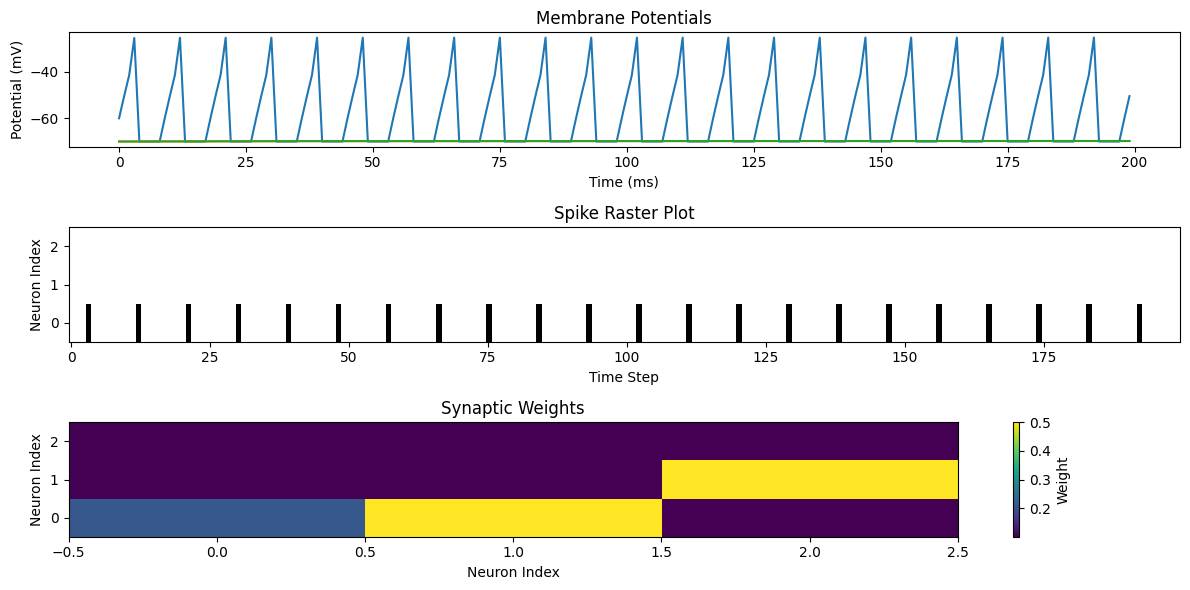

[[0.         0.         0.        ]
 [0.63341033 0.         0.        ]
 [0.         0.65013176 0.        ]]


In [14]:
# AdEx neuron dynamics
def adex_dynamics(state, neuron_params, inputs):
    """AdEx neuron dynamics with spiking and refractory period."""
    v, w, refractory_timer = state
    I_ext, I_syn = inputs

    refractory_logic = lambda _: (
        neuron_params["v_reset"], w, refractory_timer - 1, 0.0
    )

    normal_logic = lambda _: (
        v + (-(v - neuron_params["v_rest"])
             + neuron_params["delta_T"] * jnp.exp((v - neuron_params["v_th"]) / neuron_params["delta_T"])
             - w + I_ext + I_syn) / neuron_params["tau_v"],
        w + (neuron_params["a"] * (v - neuron_params["v_rest"]) - w +
             neuron_params["b"] * (v > neuron_params["v_th"])) / neuron_params["tau_w"],
        jnp.where(v > neuron_params["v_th"], neuron_params["refractory"], 0.0),
        (v > neuron_params["v_th"]).astype(float)
    )

    v_new, w_new, refractory_timer_new, spiked = jax.lax.cond(
        refractory_timer > 0, refractory_logic, normal_logic, operand=None
    )

    return jnp.array([v_new, w_new, refractory_timer_new]), spiked

# Exponential synapse dynamics
def synaptic_dynamics(syn_state, syn_params, pre_spike):
    """Exponential synaptic dynamics."""
    return syn_state + (-syn_state / syn_params["tau_syn"] + pre_spike * 1.0)

# STDP weight updates
def update_weights(weights, pre_spikes, post_spikes, stdp_params):
    """Update synaptic weights using STDP rules."""
    delta_w_plus = stdp_params["A_plus"] * pre_spikes[:, None] * post_spikes[None, :]
    delta_w_minus = stdp_params["A_minus"] * post_spikes[:, None] * pre_spikes[None, :]
    weights += delta_w_plus - delta_w_minus
    return jnp.clip(weights, 0.1, 1.5)  # Adjust weight limits as needed

# Network update function
def network_update(carry, t, params):
    neuron_states, synapse_states, weights, key = carry
    key, subkey = random.split(key)

    # External input: stimulate neuron 0 for demonstration
    I_ext = jnp.zeros(len(neuron_states))
    I_ext = I_ext.at[0].set(200.0)  # Stimulate neuron 0

    pre_spikes = (neuron_states[:, 0] > params["neuron"]["v_th"]).astype(float)

    # Synaptic dynamics: update synapse states
    synapse_states = jax.vmap(synaptic_dynamics, in_axes=(0, None, 0))(
        synapse_states, params["synapse"], pre_spikes
    )
    I_syn = jnp.dot(weights, synapse_states)

    # Neuron dynamics: update states
    neuron_states, spiked = jax.vmap(adex_dynamics, in_axes=(0, None, 0))(
        neuron_states, params["neuron"], jnp.stack([I_ext, I_syn], axis=-1)
    )

    # Update weights
    weights = update_weights(weights, pre_spikes, spiked, params["stdp"])

    return (neuron_states, synapse_states, weights, key), (neuron_states[:, 0], spiked)

# Simulation
def simulate(T, dt, N, key, params, connectivity):
    neuron_states = jnp.stack([
        jnp.full((N,), params["neuron"]["v_rest"]),
        jnp.zeros(N),
        jnp.zeros(N)
    ], axis=-1)
    synapse_states = jnp.zeros(N)
    weights = jnp.array(connectivity) * 0.5
    carry = (neuron_states, synapse_states, weights, key)
    time_steps = jnp.arange(0, T, dt)

    carry, outputs = scan(lambda carry, t: network_update(carry, t, params), carry, time_steps)
    membrane_potentials, spikes = outputs
    return jnp.array(membrane_potentials).T, jnp.array(spikes).T, carry[2], time_steps

# Plotting results
def plot_results(time, membrane_potentials, spikes, weights):
    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 1)
    plt.plot(time, membrane_potentials.T)
    plt.title("Membrane Potentials")
    plt.xlabel("Time (ms)")
    plt.ylabel("Potential (mV)")

    plt.subplot(3, 1, 2)
    plt.imshow(spikes, aspect="auto", cmap="gray_r", origin="lower")
    plt.title("Spike Raster Plot")
    plt.xlabel("Time Step")
    plt.ylabel("Neuron Index")

    plt.subplot(3, 1, 3)
    plt.imshow(weights, aspect="auto", cmap="viridis", origin="lower")
    plt.title("Synaptic Weights")
    plt.xlabel("Neuron Index")
    plt.ylabel("Neuron Index")
    plt.colorbar(label="Weight")
    plt.tight_layout()
    plt.show()

# Define the connectivity matrix
N = 3
connectivity = jnp.array([
    [0.0, 1.0, 0.0],  # Neuron 0 connects to Neuron 1
    [0.0, 0.0, 1.0],  # Neuron 1 connects to Neuron 2
    [0.0, 0.0, 0.0]   # Neuron 2 has no outgoing connections
])

# Simulation parameters
key = random.PRNGKey(42)
T = 200  # Simulation time (ms)
dt = 1.0  # Time step (ms)

# Run the simulation
membrane_potentials, spikes, final_weights, time = simulate(T, dt, N, key, params, connectivity)
plot_results(time, membrane_potentials, spikes, final_weights)
print(weights)